In [1]:
pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 7.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import os
import kaggle
import torch
from sklearn.model_selection import train_test_split


In [3]:
os.getcwd()

'/home/jovyan/work'

In [5]:
os.chdir('./data')

In [6]:
os.listdir()

['classicRec.png',
 'DeepRec.png',
 'Users.csv',
 'Ratings.csv',
 'Books.csv',
 'recsys_taxonomy2.png']

In [7]:
# if not os.path.exists('./Books.csv'):
#   kaggle.api.dataset_download_files('arashnic/book-recommendation-dataset',
#                                     path='./', unzip=True)
#   print("Dataset downloaded successfully")
# else:
#   print("Dataset already exists")

In [8]:
books = pd.read_csv('Books.csv')
ratings = pd.read_csv('Ratings.csv')
users = pd.read_csv('Users.csv')

/tmp/ipykernel_77/378180666.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('Books.csv')


In [21]:
# Lemme check the first few rows
print(users.head(5))
print(ratings.head(5))
print(books.head(5))

   User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN
   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication              

In [36]:
# Check shapes and basic stats
print(f"Users: {users.shape}")
print(f"Ratings: {ratings.shape}")  
print(f"Books: {books.shape}")

# Examine the rating distribution
ratings['Book-Rating'].value_counts().sort_index()

Users: (278858, 3)
Ratings: (1149780, 3)
Books: (271360, 8)


Book-Rating
0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: count, dtype: int64

In [37]:
# Check what columns we have
print("Users columns:", users.columns.tolist())
print("Ratings columns:", ratings.columns.tolist())  
print("Books columns:", books.columns.tolist())

# For users - we probably only need User-ID for merging
# Location/Age might be useful later for cold-start but not for basic CF
users_clean = users[['User-ID']]

# For ratings - we need all three columns
ratings_clean = ratings[['User-ID', 'ISBN', 'Book-Rating']]

# For books - drop the image URLs, keep core metadata
books_clean = books[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication']]

Users columns: ['User-ID', 'Location', 'Age']
Ratings columns: ['User-ID', 'ISBN', 'Book-Rating']
Books columns: ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


In [38]:
# First merge ratings with books (on ISBN)
rating_books = ratings_clean.merge(books_clean, on='ISBN', how='inner')

# Filter to explicit ratings before any user operations
explicit_only = rating_books[rating_books['Book-Rating'] > 0]

In [39]:
print(f"Explicit ratings shape: {explicit_only.shape}")
print(f"Unique users: {explicit_only['User-ID'].nunique()}")
print(f"Unique books: {explicit_only['Book-Title'].nunique()}")

# Check sparsity before filtering
n_users = explicit_only['User-ID'].nunique()
n_books = explicit_only['Book-Title'].nunique()
n_ratings = explicit_only.shape[0]
sparsity = 1 - (n_ratings / (n_users * n_books))
print(f"Sparsity: {sparsity:.4f}")

Explicit ratings shape: (383842, 6)
Unique users: 68091
Unique books: 135567
Sparsity: 1.0000


In [40]:
# Count ratings per book and per user
book_counts = explicit_only.groupby('Book-Title').size()
user_counts = explicit_only.groupby('User-ID').size()

print(f"Books with ≥50 ratings: {(book_counts >= 50).sum()}")
print(f"Users with ≥20 ratings: {(user_counts >= 20).sum()}")

# Apply thresholds
min_book_ratings = 50
min_user_ratings = 20

popular_books = book_counts[book_counts >= min_book_ratings].index
active_users = user_counts[user_counts >= min_user_ratings].index

# Filter to popular books and active users
filtered_data = explicit_only[
    (explicit_only['Book-Title'].isin(popular_books)) &
    (explicit_only['User-ID'].isin(active_users))
]

print(f"Final dataset shape: {filtered_data.shape}")
print(f"Final users: {filtered_data['User-ID'].nunique()}")
print(f"Final books: {filtered_data['Book-Title'].nunique()}")

# Recalculate sparsity
final_sparsity = 1 - (filtered_data.shape[0] / (filtered_data['User-ID'].nunique() * filtered_data['Book-Title'].nunique()))
print(f"Final sparsity: {final_sparsity:.4f}")

Books with ≥50 ratings: 651
Users with ≥20 ratings: 3305
Final dataset shape: (30479, 6)
Final users: 2978
Final books: 651
Final sparsity: 0.9843


In [41]:
# Split the filtered_data into train/test
# We need to be careful with collaborative filtering splits
train_data, test_data = train_test_split(
    filtered_data, 
    test_size=0.2, 
    random_state=42, 
    stratify=None  # Don't stratify for collaborative filtering
)

print(f"Train set: {train_data.shape[0]} ratings")
print(f"Test set: {test_data.shape[0]} ratings")

# Check that we still have reasonable coverage
print(f"Train users: {train_data['User-ID'].nunique()}")
print(f"Train books: {train_data['Book-Title'].nunique()}")
print(f"Test users: {test_data['User-ID'].nunique()}")
print(f"Test books: {test_data['Book-Title'].nunique()}")

Train set: 24383 ratings
Test set: 6096 ratings
Train users: 2921
Train books: 651
Test users: 2104
Test books: 650


In [42]:
# Create the rating matrix using ONLY training data
R_train = train_data.pivot_table(
    index='User-ID',
    columns='Book-Title', 
    values='Book-Rating'
)

# Create indicator matrix for observed ratings in training set
observed_mask_train = ~R_train.isna()
R_filled_train = R_train.fillna(0)

# For evaluation, create test mask aligned with training matrix structure
test_pivot = test_data.pivot_table(
    index='User-ID',
    columns='Book-Title',
    values='Book-Rating'
)

# Align test data with training matrix dimensions
test_aligned = test_pivot.reindex(index=R_train.index, columns=R_train.columns)
observed_mask_test = ~test_aligned.isna()
R_filled_test = test_aligned.fillna(0)

In [43]:
# Set dimensions from our filtered data
n_users, n_items = R_filled_train.shape
k = 5  # Number of latent factors

print(f"Matrix dimensions: {n_users} users × {n_items} items")
print(f"Latent factors: {k}")

# Convert to tensors
R_tensor = torch.tensor(R_filled_train.values, dtype=torch.float32)
mask_tensor = torch.tensor(observed_mask_train.values, dtype=torch.bool)

# Normalize ratings from [1,10] to [0,1] as per the paper
R_normalized = (R_tensor - 1) / 9.0

print(f"Observed ratings: {mask_tensor.sum().item()}")
print(f"Rating range after normalization: [{R_normalized[mask_tensor].min():.3f}, {R_normalized[mask_tensor].max():.3f}]")

Matrix dimensions: 2921 users × 651 items
Latent factors: 5
Observed ratings: 24131
Rating range after normalization: [0.000, 1.000]


In [44]:
# Variational parameters for mean-field approximation
# U_i ~ N(μ_ui, diag(σ²_ui)), V_j ~ N(μ_vj, diag(σ²_vj))

# Initialize means
mu_U = torch.randn(n_users, k) * 0.1  # Small random initialization
mu_V = torch.randn(n_items, k) * 0.1

# Initialize log variances (we work in log space for numerical stability)
log_var_U = torch.full((n_users, k), -2.0)  # exp(-2) ≈ 0.135
log_var_V = torch.full((n_items, k), -2.0)

# Hyperparameters
sigma_noise = 0.2  # Observation noise
sigma_prior = 0.5  # Prior variance

print(f"Initial user factor mean range: [{mu_U.min():.3f}, {mu_U.max():.3f}]")
print(f"Initial item factor mean range: [{mu_V.min():.3f}, {mu_V.max():.3f}]")

Initial user factor mean range: [-0.382, 0.351]
Initial item factor mean range: [-0.338, 0.340]


In [45]:
def compute_elbo_point_estimate(mu_U, log_var_U, mu_V, log_var_V, R_normalized, mask_tensor, 
                               sigma_noise, sigma_prior):
    """
    ELBO with point estimate approximation for sigmoid expectations
    """
    # Point estimate: sigmoid(E[U_i^T V_j]) instead of E[sigmoid(U_i^T V_j)]
    predictions = torch.sigmoid(mu_U @ mu_V.T)
    
    # Likelihood term (Gaussian likelihood around sigmoid predictions)
    likelihood_term = -0.5 * torch.sum(
        mask_tensor * (R_normalized - predictions)**2
    ) / (sigma_noise**2)
    
    # KL divergence: KL(N(μ,σ²) || N(0,σ_prior²))
    kl_U = 0.5 * torch.sum(
        (torch.exp(log_var_U) + mu_U**2) / (sigma_prior**2) - 1 - log_var_U + 2*torch.log(torch.tensor(sigma_prior))
    )
    
    kl_V = 0.5 * torch.sum(
        (torch.exp(log_var_V) + mu_V**2) / (sigma_prior**2) - 1 - log_var_V + 2*torch.log(torch.tensor(sigma_prior))
    )
    
    elbo = likelihood_term - kl_U - kl_V
    return elbo, likelihood_term, kl_U, kl_V

def quantify_sigmoid_bias(mu_U, log_var_U, mu_V, log_var_V, n_samples=1000):
    """
    Quantify bias in point estimate approximation using Monte Carlo
    """
    # Point estimate approximation
    point_estimates = torch.sigmoid(mu_U @ mu_V.T)
    
    # Monte Carlo approximation of E[sigmoid(U_i^T V_j)]
    var_U = torch.exp(log_var_U)
    var_V = torch.exp(log_var_V)
    
    mc_estimates = []
    for _ in range(n_samples):
        U_sample = torch.randn_like(mu_U) * torch.sqrt(var_U) + mu_U
        V_sample = torch.randn_like(mu_V) * torch.sqrt(var_V) + mu_V
        mc_estimates.append(torch.sigmoid(U_sample @ V_sample.T))
    
    mc_mean = torch.stack(mc_estimates).mean(0)
    
    # Compute bias statistics
    bias = (point_estimates - mc_mean).abs()
    
    return {
        'mean_bias': bias.mean().item(),
        'max_bias': bias.max().item(),
        'median_bias': bias.median().item(),
        'bias_std': bias.std().item()
    }

# Test initial ELBO and bias
elbo_initial, likelihood, kl_u, kl_v = compute_elbo_point_estimate(
    mu_U, log_var_U, mu_V, log_var_V, R_normalized, mask_tensor, sigma_noise, sigma_prior
)

print(f"Initial ELBO: {elbo_initial.item():.4f}")
print(f"  Likelihood: {likelihood.item():.4f}")  
print(f"  KL(U): {kl_u.item():.4f}")
print(f"  KL(V): {kl_v.item():.4f}")

# Quantify approximation bias
bias_stats = quantify_sigmoid_bias(mu_U, log_var_U, mu_V, log_var_V)
print(f"\nSigmoid approximation bias:")
print(f"  Mean: {bias_stats['mean_bias']:.6f}")
print(f"  Max: {bias_stats['max_bias']:.6f}")  
print(f"  Median: {bias_stats['median_bias']:.6f}")
print(f"  Std: {bias_stats['bias_std']:.6f}")

Initial ELBO: -35800.4180
  Likelihood: -34056.1406
  KL(U): 1428.1345
  KL(V): 316.1451

Sigmoid approximation bias:
  Mean: 0.001979
  Max: 0.012523
  Median: 0.001673
  Std: 0.001496


In [46]:
def coordinate_ascent_step(mu_U, log_var_U, mu_V, log_var_V, R_normalized, mask_tensor, 
                          sigma_noise, sigma_prior, learning_rate=0.01):
    """
    Single coordinate ascent step using gradient updates on ELBO
    """
    # Enable gradients
    mu_U.requires_grad_(True)
    log_var_U.requires_grad_(True) 
    mu_V.requires_grad_(True)
    log_var_V.requires_grad_(True)
    
    # Compute ELBO
    elbo, _, _, _ = compute_elbo_point_estimate(
        mu_U, log_var_U, mu_V, log_var_V, R_normalized, mask_tensor, sigma_noise, sigma_prior
    )
    
    # Gradient ascent (maximize ELBO)
    elbo.backward()
    
    with torch.no_grad():
        mu_U += learning_rate * mu_U.grad
        log_var_U += learning_rate * log_var_U.grad
        mu_V += learning_rate * mu_V.grad  
        log_var_V += learning_rate * log_var_V.grad
        
        # Zero gradients
        mu_U.grad.zero_()
        log_var_U.grad.zero_()
        mu_V.grad.zero_()
        log_var_V.grad.zero_()
    
    return elbo.item()

Starting CAVI training...
Epoch	ELBO		ΔELBO		Bias(mean/max)
------------------------------------------------------------
1	-35786.2539	14.164062	0.006244/0.041742
2	-35772.3867	13.867188	0.006247/0.039267
3	-35758.7930	13.593750	0.006222/0.042068
4	-35745.4492	13.343750	0.006251/0.042210
5	-35732.3359	13.113281	0.006233/0.039707
6	-35719.4297	12.906250	0.006253/0.037883
7	-35706.7188	12.710938	0.006240/0.039726
8	-35694.1641	12.554688	0.006221/0.040306
9	-35681.7695	12.394531	0.006235/0.040575
10	-35669.5039	12.265625	0.006218/0.042351
20	-35550.1797	11.921875	0.006238/0.044819
30	-35423.7695	13.585938	0.006264/0.038888
40	-35264.6484	18.484375	0.006292/0.042204
50	-35024.0703	30.027344	0.006370/0.044774
60	-34599.7148	55.390625	0.006452/0.052992
70	-33801.8906	103.550781	0.006562/0.057453
80	-32398.1758	172.498047	0.006856/0.074381
90	-30277.3281	242.787109	0.007244/0.100652
100	-27568.0898	288.197266	0.007834/0.115143
110	-24648.7266	287.572266	0.008538/0.112254
120	-21976.9121	246.1

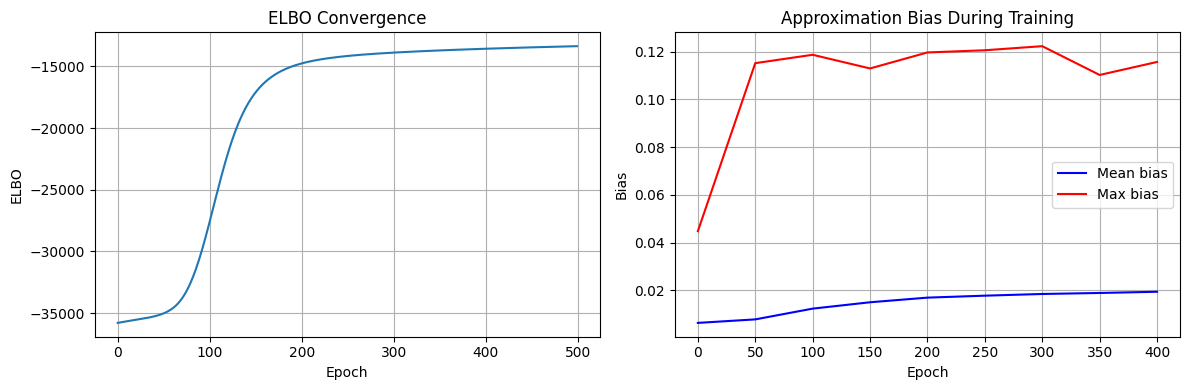


Final bias assessment:
  Mean: 0.017174
  Max: 0.070269


In [47]:
def train_bayesian_mf(mu_U, log_var_U, mu_V, log_var_V, R_normalized, mask_tensor,
                     sigma_noise, sigma_prior, max_epochs=500, learning_rate=0.01,
                     convergence_tol=1e-4, bias_check_interval=50):
    """
    Train Bayesian Matrix Factorization using gradient-based coordinate ascent
    """
    elbo_history = []
    bias_history = []
    
    print("Starting CAVI training...")
    print(f"Epoch\tELBO\t\tΔELBO\t\tBias(mean/max)")
    print("-" * 60)
    
    for epoch in range(max_epochs):
        # Single coordinate ascent step
        current_elbo = coordinate_ascent_step(
            mu_U, log_var_U, mu_V, log_var_V, R_normalized, mask_tensor,
            sigma_noise, sigma_prior, learning_rate
        )
        
        elbo_history.append(current_elbo)
        
        # Check convergence
        if len(elbo_history) > 1:
            delta_elbo = elbo_history[-1] - elbo_history[-2]
            
            # Print progress
            if epoch % 10 == 0 or epoch < 10:
                bias_stats = quantify_sigmoid_bias(mu_U, log_var_U, mu_V, log_var_V, n_samples=100)
                if epoch % bias_check_interval == 0:
                    bias_history.append(bias_stats)
                
                print(f"{epoch}\t{current_elbo:.4f}\t{delta_elbo:.6f}\t{bias_stats['mean_bias']:.6f}/{bias_stats['max_bias']:.6f}")
            
            # Convergence check
            if abs(delta_elbo) < convergence_tol:
                print(f"\nConverged at epoch {epoch}")
                break
    
    # Final bias assessment
    final_bias = quantify_sigmoid_bias(mu_U, log_var_U, mu_V, log_var_V, n_samples=1000)
    
    return {
        'elbo_history': elbo_history,
        'bias_history': bias_history,
        'final_bias': final_bias,
        'converged_epoch': epoch
    }

# Train the model
training_results = train_bayesian_mf(
    mu_U, log_var_U, mu_V, log_var_V, R_normalized, mask_tensor,
    sigma_noise, sigma_prior, max_epochs=500, learning_rate=0.001
)

# Plot convergence
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_results['elbo_history'])
plt.title('ELBO Convergence')
plt.xlabel('Epoch')
plt.ylabel('ELBO')
plt.grid(True)

plt.subplot(1, 2, 2)
if training_results['bias_history']:
    bias_means = [b['mean_bias'] for b in training_results['bias_history']]
    bias_maxs = [b['max_bias'] for b in training_results['bias_history']]
    epochs = list(range(0, len(bias_means) * 50, 50))
    
    plt.plot(epochs, bias_means, 'b-', label='Mean bias')
    plt.plot(epochs, bias_maxs, 'r-', label='Max bias') 
    plt.title('Approximation Bias During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Bias')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal bias assessment:")
print(f"  Mean: {training_results['final_bias']['mean_bias']:.6f}")
print(f"  Max: {training_results['final_bias']['max_bias']:.6f}")

In [48]:
def evaluate_on_test_set(mu_U, mu_V, test_data_aligned, test_mask):
    """Evaluate trained model on held-out test set with proper normalization"""
    
    # Normalize test ratings to [0,1] scale (same as training)
    R_test_normalized = (torch.tensor(test_data_aligned.fillna(0).values, dtype=torch.float32) - 1) / 9.0
    test_mask_tensor = torch.tensor(test_mask.values, dtype=torch.bool)
    
    # Generate predictions using trained model
    predictions = torch.sigmoid(mu_U @ mu_V.T)
    
    # Check if we have any test ratings to evaluate
    if test_mask_tensor.sum() == 0:
        print("No test ratings available for evaluation")
        return None, None
    
    # Extract test predictions and true values
    test_preds = predictions[test_mask_tensor]
    test_true = R_test_normalized[test_mask_tensor]
    
    # Compute metrics
    rmse = torch.sqrt(torch.mean((test_preds - test_true)**2))
    mae = torch.mean(torch.abs(test_preds - test_true))
    
    print(f"Test set evaluation:")
    print(f"  RMSE: {rmse.item():.4f} (normalized scale)")
    print(f"  MAE: {mae.item():.4f} (normalized scale)")
    print(f"  RMSE (1-10 scale): {rmse.item() * 9:.4f}")
    print(f"  Test ratings evaluated: {test_mask_tensor.sum().item()}")
    
    return rmse.item(), mae.item()

# Run the evaluation
test_rmse, test_mae = evaluate_on_test_set(mu_U, mu_V, test_aligned, observed_mask_test)

# Compare with training performance
train_predictions = torch.sigmoid(mu_U @ mu_V.T)
train_mask_tensor = torch.tensor(observed_mask_train.values, dtype=torch.bool)
train_true = (torch.tensor(R_filled_train.values, dtype=torch.float32) - 1) / 9.0

train_preds = train_predictions[train_mask_tensor] 
train_actual = train_true[train_mask_tensor]
train_rmse = torch.sqrt(torch.mean((train_preds - train_actual)**2))

print(f"\nComparison:")
print(f"  Training RMSE: {train_rmse.item():.4f}")
print(f"  Test RMSE: {test_rmse:.4f}")
print(f"  Generalization gap: {test_rmse - train_rmse.item():.4f}")

# Implement correlation diagnostics we discussed earlier
def compute_correlation_diagnostics(mu_U, mu_V):
    # Correlations between latent factors (k x k matrices)
    user_factor_corr = torch.corrcoef(mu_U.T)  # 10x10 correlation between factors
    item_factor_corr = torch.corrcoef(mu_V.T)  # 10x10 correlation between factors
    
    # Remove diagonal elements (self-correlation = 1)
    user_factor_corr_off_diag = user_factor_corr.clone()
    user_factor_corr_off_diag.fill_diagonal_(0)
    
    item_factor_corr_off_diag = item_factor_corr.clone() 
    item_factor_corr_off_diag.fill_diagonal_(0)
    
    return {
        'max_user_factor_corr': user_factor_corr_off_diag.abs().max().item(),
        'max_item_factor_corr': item_factor_corr_off_diag.abs().max().item(),
        'mean_user_factor_corr': user_factor_corr_off_diag.abs().mean().item(),
        'mean_item_factor_corr': item_factor_corr_off_diag.abs().mean().item()
    }

corr_diag = compute_correlation_diagnostics(mu_U, mu_V)
print(f"\nCorrelation diagnostics:")
for key, value in corr_diag.items():
    print(f"  {key}: {value:.4f}")

Test set evaluation:
  RMSE: 0.1872 (normalized scale)
  MAE: 0.1483 (normalized scale)
  RMSE (1-10 scale): 1.6845
  Test ratings evaluated: 6016

Comparison:
  Training RMSE: 0.1428
  Test RMSE: 0.1872
  Generalization gap: 0.0444

Correlation diagnostics:
  max_user_factor_corr: 0.4696
  max_item_factor_corr: 0.1702
  mean_user_factor_corr: 0.1598
  mean_item_factor_corr: 0.0525


In [49]:
# --- Sanity check: mu_V musí mít stejný počet řádků jako R_filled_train má sloupců ---
num_books = R_filled_train.shape[1]
if mu_V.shape[0] != num_books:
    raise RuntimeError(
        f"Chyba tvarů: mu_V má {mu_V.shape[0]} řádků, ale R_filled_train má {num_books} sloupců. "
        "Znovu inicializuj mu_V/log_var_V až po vytvoření R_filled_train (filtrování knih)."
    )

def make_recommendations_with_uncertainty_minimal(
    user_idx, mu_U, log_var_U, mu_V, log_var_V,
    R_filled_train, observed_mask_train, n_samples=500, top_k=5
):
    """
    Minimální úprava původní funkce:
      - vektorový Monte Carlo sampling (rychlejší)
      - confidence intervaly oříznuty do [1,10]
    Předpoklad: user_idx je INTERNÍ index (0-based) do R_filled_train řádků.
    """
    # 1) maska (ponecháme původní styl, ale použijeme numpy pro pozice)
    user_ratings_mask = observed_mask_train.iloc[user_idx]      # pandas Series (index = sloupce knih)
    unrated_bool = ~user_ratings_mask
    if unrated_bool.sum() == 0:
        return "User has rated all books in filtered dataset"

    # 2) point estimate (stejné jako původně)
    point_predictions = torch.sigmoid(mu_U[user_idx] @ mu_V.T)  # shape: (num_books,)

    # 3) variances
    var_U_user = torch.exp(log_var_U[user_idx])   # (k,)
    var_V = torch.exp(log_var_V)                  # (num_books, k)

    # 4) vektorový Monte Carlo (batch)
    n_books = mu_V.shape[0]
    k = mu_V.shape[1]

    # u_samples: (n_samples, k)
    u_samples = mu_U[user_idx].unsqueeze(0) + torch.randn((n_samples, k)) * torch.sqrt(var_U_user).unsqueeze(0)

    # v_samples: (n_samples, n_books, k)
    v_noise = torch.randn((n_samples, n_books, k)) * torch.sqrt(var_V).unsqueeze(0)
    v_samples = mu_V.unsqueeze(0) + v_noise

    # predictions per sample: (n_samples, n_books)
    dots = torch.bmm(v_samples, u_samples.unsqueeze(2)).squeeze(2)
    mc_preds = torch.sigmoid(dots)  # (n_samples, n_books)

    mc_mean = mc_preds.mean(dim=0)  # (n_books,)
    mc_std = mc_preds.std(dim=0)    # (n_books,)

    # 5) unrated positions
    unrated_positions = np.where(unrated_bool.to_numpy())[0]  # numpy array of ints
    if len(unrated_positions) == 0:
        return "User has rated all books in filtered dataset"

    unrated_positions_t = torch.tensor(unrated_positions, dtype=torch.long)

    # 6) Řazení podle nejistoty (vzestupně = od nejvyšší jistoty)
    unrated_point_preds = point_predictions[unrated_positions_t]
    unrated_unc = mc_std[unrated_positions_t]
    
    # --- ZDE JE OPRAVA ---
    # Řadíme vzestupně (descending=False), protože chceme nejnižší nejistotu.
    sorted_idx = torch.argsort(unrated_unc, descending=False)[:top_k]
    
    recommended_positions = unrated_positions_t[sorted_idx] # global column positions (tensor)
    
    # 7) titles
    rec_pos_np = recommended_positions.cpu().numpy().tolist()
    book_titles = R_filled_train.columns[rec_pos_np]

    # 8) scale predictions and uncertainties to 1-10 and compute CI (clipped)
    pred_selected = unrated_point_preds[sorted_idx]
    unc_selected = unrated_unc[sorted_idx]

    pred_scaled = pred_selected * 9.0 + 1.0
    unc_scaled = unc_selected * 9.0

    lower = torch.clamp(pred_scaled - 1.96 * unc_scaled, min=1.0, max=10.0)
    upper = torch.clamp(pred_scaled + 1.96 * unc_scaled, min=1.0, max=10.0)

    return {
        'book_titles': book_titles.tolist(),
        'predicted_ratings': pred_scaled.tolist(),
        'uncertainties': unc_scaled.tolist(),
        'confidence_intervals': list(zip(lower.tolist(), upper.tolist())),
        'user_idx': user_idx
    }

# --- Helper: volat interní index (to jest co ti dříve fungovalo: user_idx = 100 je interní index) ---
def recommend_for_internal_user_idx(user_idx, top_n=10, n_samples=500):
    rec = make_recommendations_with_uncertainty_minimal(
        user_idx, mu_U, log_var_U, mu_V, log_var_V, R_filled_train, observed_mask_train,
        n_samples=n_samples, top_k=top_n
    )
    if isinstance(rec, str):
        print(rec)
        return rec

    print(f"\nRecommendations for internal user_idx {rec['user_idx']}:")
    print("=" * 70)
    for i, (title, rating, uncertainty, ci) in enumerate(zip(
        rec['book_titles'], rec['predicted_ratings'], rec['uncertainties'], rec['confidence_intervals']
    ), 1):
        unc_level = "High" if uncertainty > 1.5 else "Medium" if uncertainty > 0.8 else "Low"
        print(f"{i}. {title}")
        print(f"   Predicted rating: {rating:.2f}/10 (±{1.96 * uncertainty:.2f})")
        print(f"   95% CI: [{ci[0]:.2f}, {ci[1]:.2f}]")
        print(f"   Uncertainty: {unc_level}\n")
    return rec


In [50]:
recommendations = recommend_for_internal_user_idx(546, top_n=10, n_samples=500)


Recommendations for internal user_idx 546:
1. Four Blondes
   Predicted rating: 5.76/10 (±1.86)
   95% CI: [3.89, 7.62]
   Uncertainty: Medium

2. Riptide
   Predicted rating: 6.74/10 (±1.88)
   95% CI: [4.86, 8.62]
   Uncertainty: Medium

3. Men Are from Mars, Women Are from Venus: A Practical Guide for Improving Communication and Getting What You Want in Your Relationships
   Predicted rating: 6.59/10 (±1.94)
   95% CI: [4.65, 8.53]
   Uncertainty: Medium

4. Paradise
   Predicted rating: 6.68/10 (±1.94)
   95% CI: [4.74, 8.62]
   Uncertainty: Medium

5. Foucault's Pendulum
   Predicted rating: 7.02/10 (±1.96)
   95% CI: [5.06, 8.98]
   Uncertainty: Medium

6. Free
   Predicted rating: 6.13/10 (±1.97)
   95% CI: [4.16, 8.10]
   Uncertainty: Medium

7. Hearts in Atlantis
   Predicted rating: 6.72/10 (±1.97)
   95% CI: [4.75, 8.70]
   Uncertainty: Medium

8. Open House
   Predicted rating: 6.55/10 (±1.99)
   95% CI: [4.57, 8.54]
   Uncertainty: Medium

9. 4 Blondes
   Predicted rating